In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

In [2]:

data=pd.read_csv("../laboratory.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [6]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      co2      so2     no2    pm1  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  507.934  2216.85  21.831  6.452   
2023-04-19 11:41:03  20.790   9.040  1.730  504.029  2216.82  21.776  6.477   
2023-04-19 11:43:05  20.789  10.338  1.726  503.302  2216.73  22.191  6.661   
2023-04-19 11:45:06  20.793   9.173  1.723  503.272  2216.77  23.159  6.771   
2023-04-19 11:47:08  20.792   8.218  1.720  503.708  2216.80  24.173  5.844   

                     dewpt  tvoc      o3   sound  pm2_5  temperature  \
date                                                                   
2023-04-19 11:39:01  6.523   0.0  27.653  57.259  7.996       19.024   
2023-04-19 11:41:03  6.466   0.0  27.600  52.367  8.203       19.012   
2023-04-19 11:43:05  6.456   0.0  27.512  52.689  8.830       19.009   
2023-04-19 11:45:06  6.458   0.0  27.481  56.539  8.191       19.012   
2023-04-19 11:

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

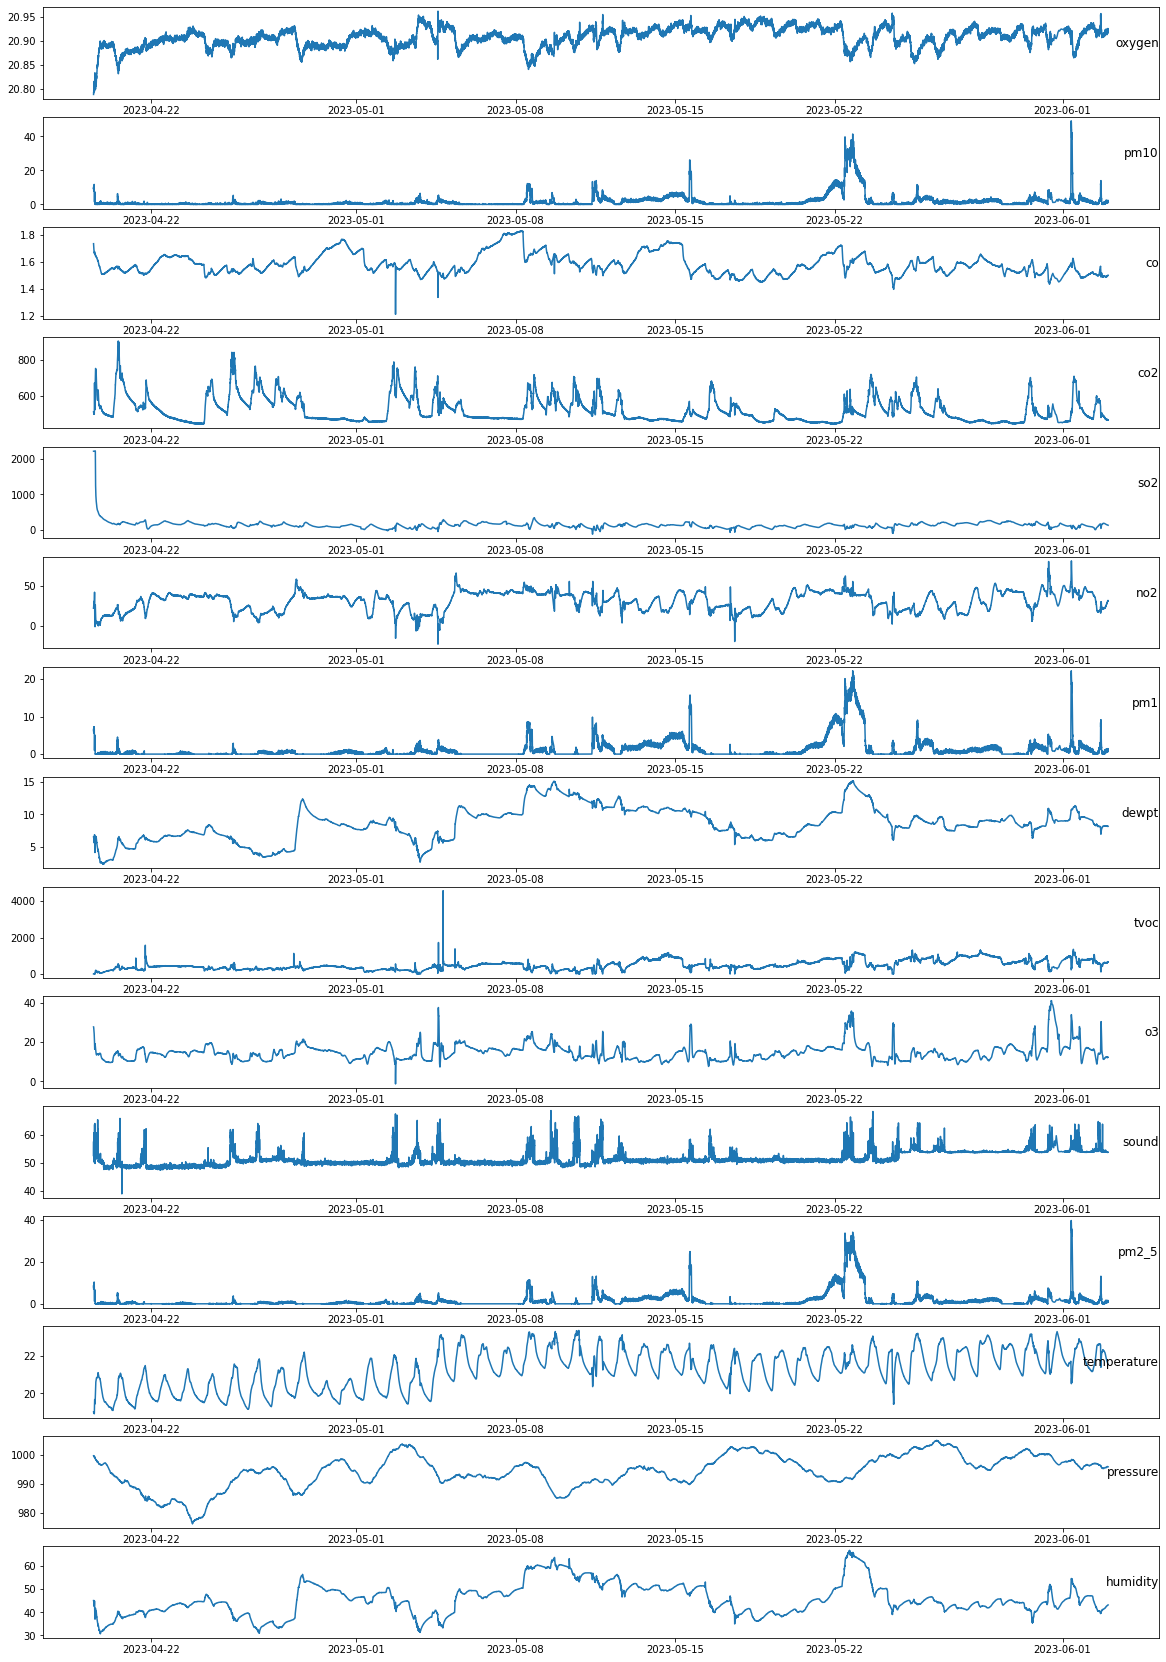

In [8]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [9]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [11]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [12]:
n_seconds = 720
n_features = 15

reframed = series_to_supervised(scaled, n_seconds, 1)

In [13]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-720),var2(t-720),var3(t-720),var4(t-720),var5(t-720),var6(t-720),var7(t-720),var8(t-720),var9(t-720),var10(t-720),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
720,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.574194,0.630011,0.114913,0.429063,0.015043,0.185340,0.077491,0.378539,0.317217,0.012206
721,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.574194,0.630300,0.114844,0.433605,0.009188,0.186660,0.076930,0.378350,0.337695,0.005548
722,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.572581,0.636081,0.114712,0.433739,0.001937,0.186893,0.080960,0.377783,0.364544,0.001337
723,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.572581,0.632039,0.114831,0.433443,0.014277,0.190077,0.080595,0.376956,0.337729,0.011324
724,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.574194,0.636372,0.114893,0.434350,0.006801,0.190931,0.081916,0.376672,0.323452,0.008953
725,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.574194,0.638103,0.115003,0.434636,0.011395,0.191707,0.080861,0.376530,0.312856,0.007944
726,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.572581,0.645916,0.115204,0.434798,0.020853,0.193804,0.080686,0.376790,0.341579,0.011853
727,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.572581,0.641245,0.115288,0.432498,0.018511,0.194037,0.080763,0.376838,0.341102,0.012534
728,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.572581,0.649649,0.115476,0.432117,0.021619,0.196211,0.081027,0.375892,0.329688,0.015233
729,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.572581,0.651906,0.115716,0.430466,0.017115,0.197609,0.080922,0.375680,0.332413,0.012685


In [14]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 10800) (28321, 12) (2427, 10800) (2427, 12)


In [15]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2427, 720, 15) (28321, 720, 15)


In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

# test3
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
197/197 - 143s - loss: 0.1043 - val_loss: 0.0601
Epoch 2/50
197/197 - 141s - loss: 0.0692 - val_loss: 0.0525
Epoch 3/50
197/197 - 135s - loss: 0.0556 - val_loss: 0.0502
Epoch 4/50
197/197 - 136s - loss: 0.0480 - val_loss: 0.0447
Epoch 5/50
197/197 - 137s - loss: 0.0427 - val_loss: 0.0377
Epoch 6/50
197/197 - 143s - loss: 0.0389 - val_loss: 0.0350
Epoch 7/50
197/197 - 138s - loss: 0.0358 - val_loss: 0.0296
Epoch 8/50
197/197 - 149s - loss: 0.0341 - val_loss: 0.0281
Epoch 9/50
197/197 - 154s - loss: 0.0326 - val_loss: 0.0251
Epoch 10/50
197/197 - 147s - loss: 0.0309 - val_loss: 0.0246
Epoch 11/50
197/197 - 145s - loss: 0.0308 - val_loss: 0.0260
Epoch 12/50
197/197 - 147s - loss: 0.0293 - val_loss: 0.0248
Epoch 13/50
197/197 - 150s - loss: 0.0298 - val_loss: 0.0245
Epoch 14/50
197/197 - 152s - loss: 0.0281 - val_loss: 0.0252
Epoch 15/50
197/197 - 142s - loss: 0.0275 - val_loss: 0.0248
Epoch 16/50
197/197 - 154s - loss: 0.0275 - val_loss: 0.0253
Epoch 17/50
197/197 - 142s - loss

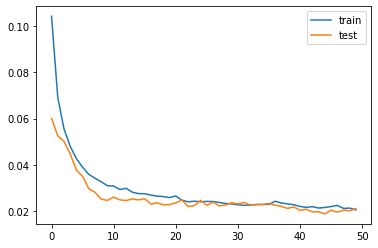

In [17]:
history = model.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6      7   \
0  20.929001  0.371  1.521  445.296997  154.873001  42.080002  0.002  8.364   
1  20.924999  0.270  1.519  446.317993  153.811005  42.009998  0.000  8.363   
2  20.927000  0.242  1.519  443.838989  153.356995  42.216000  0.072  8.361   
3  20.926001  0.446  1.519  443.377014  153.150009  42.146999  0.126  8.357   
4  20.927000  1.010  1.519  443.618988  153.292007  42.096004  0.013  8.354   

           8          9          10     11  
0  673.869019  15.639999  53.695000  0.004  
1  662.783997  15.596998  53.694000  0.006  
2  653.749023  15.551000  53.675999  0.176  
3  645.656006  15.580999  53.896000  0.326  
4  652.192017  15.575000  54.110001  0.043  


In [19]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


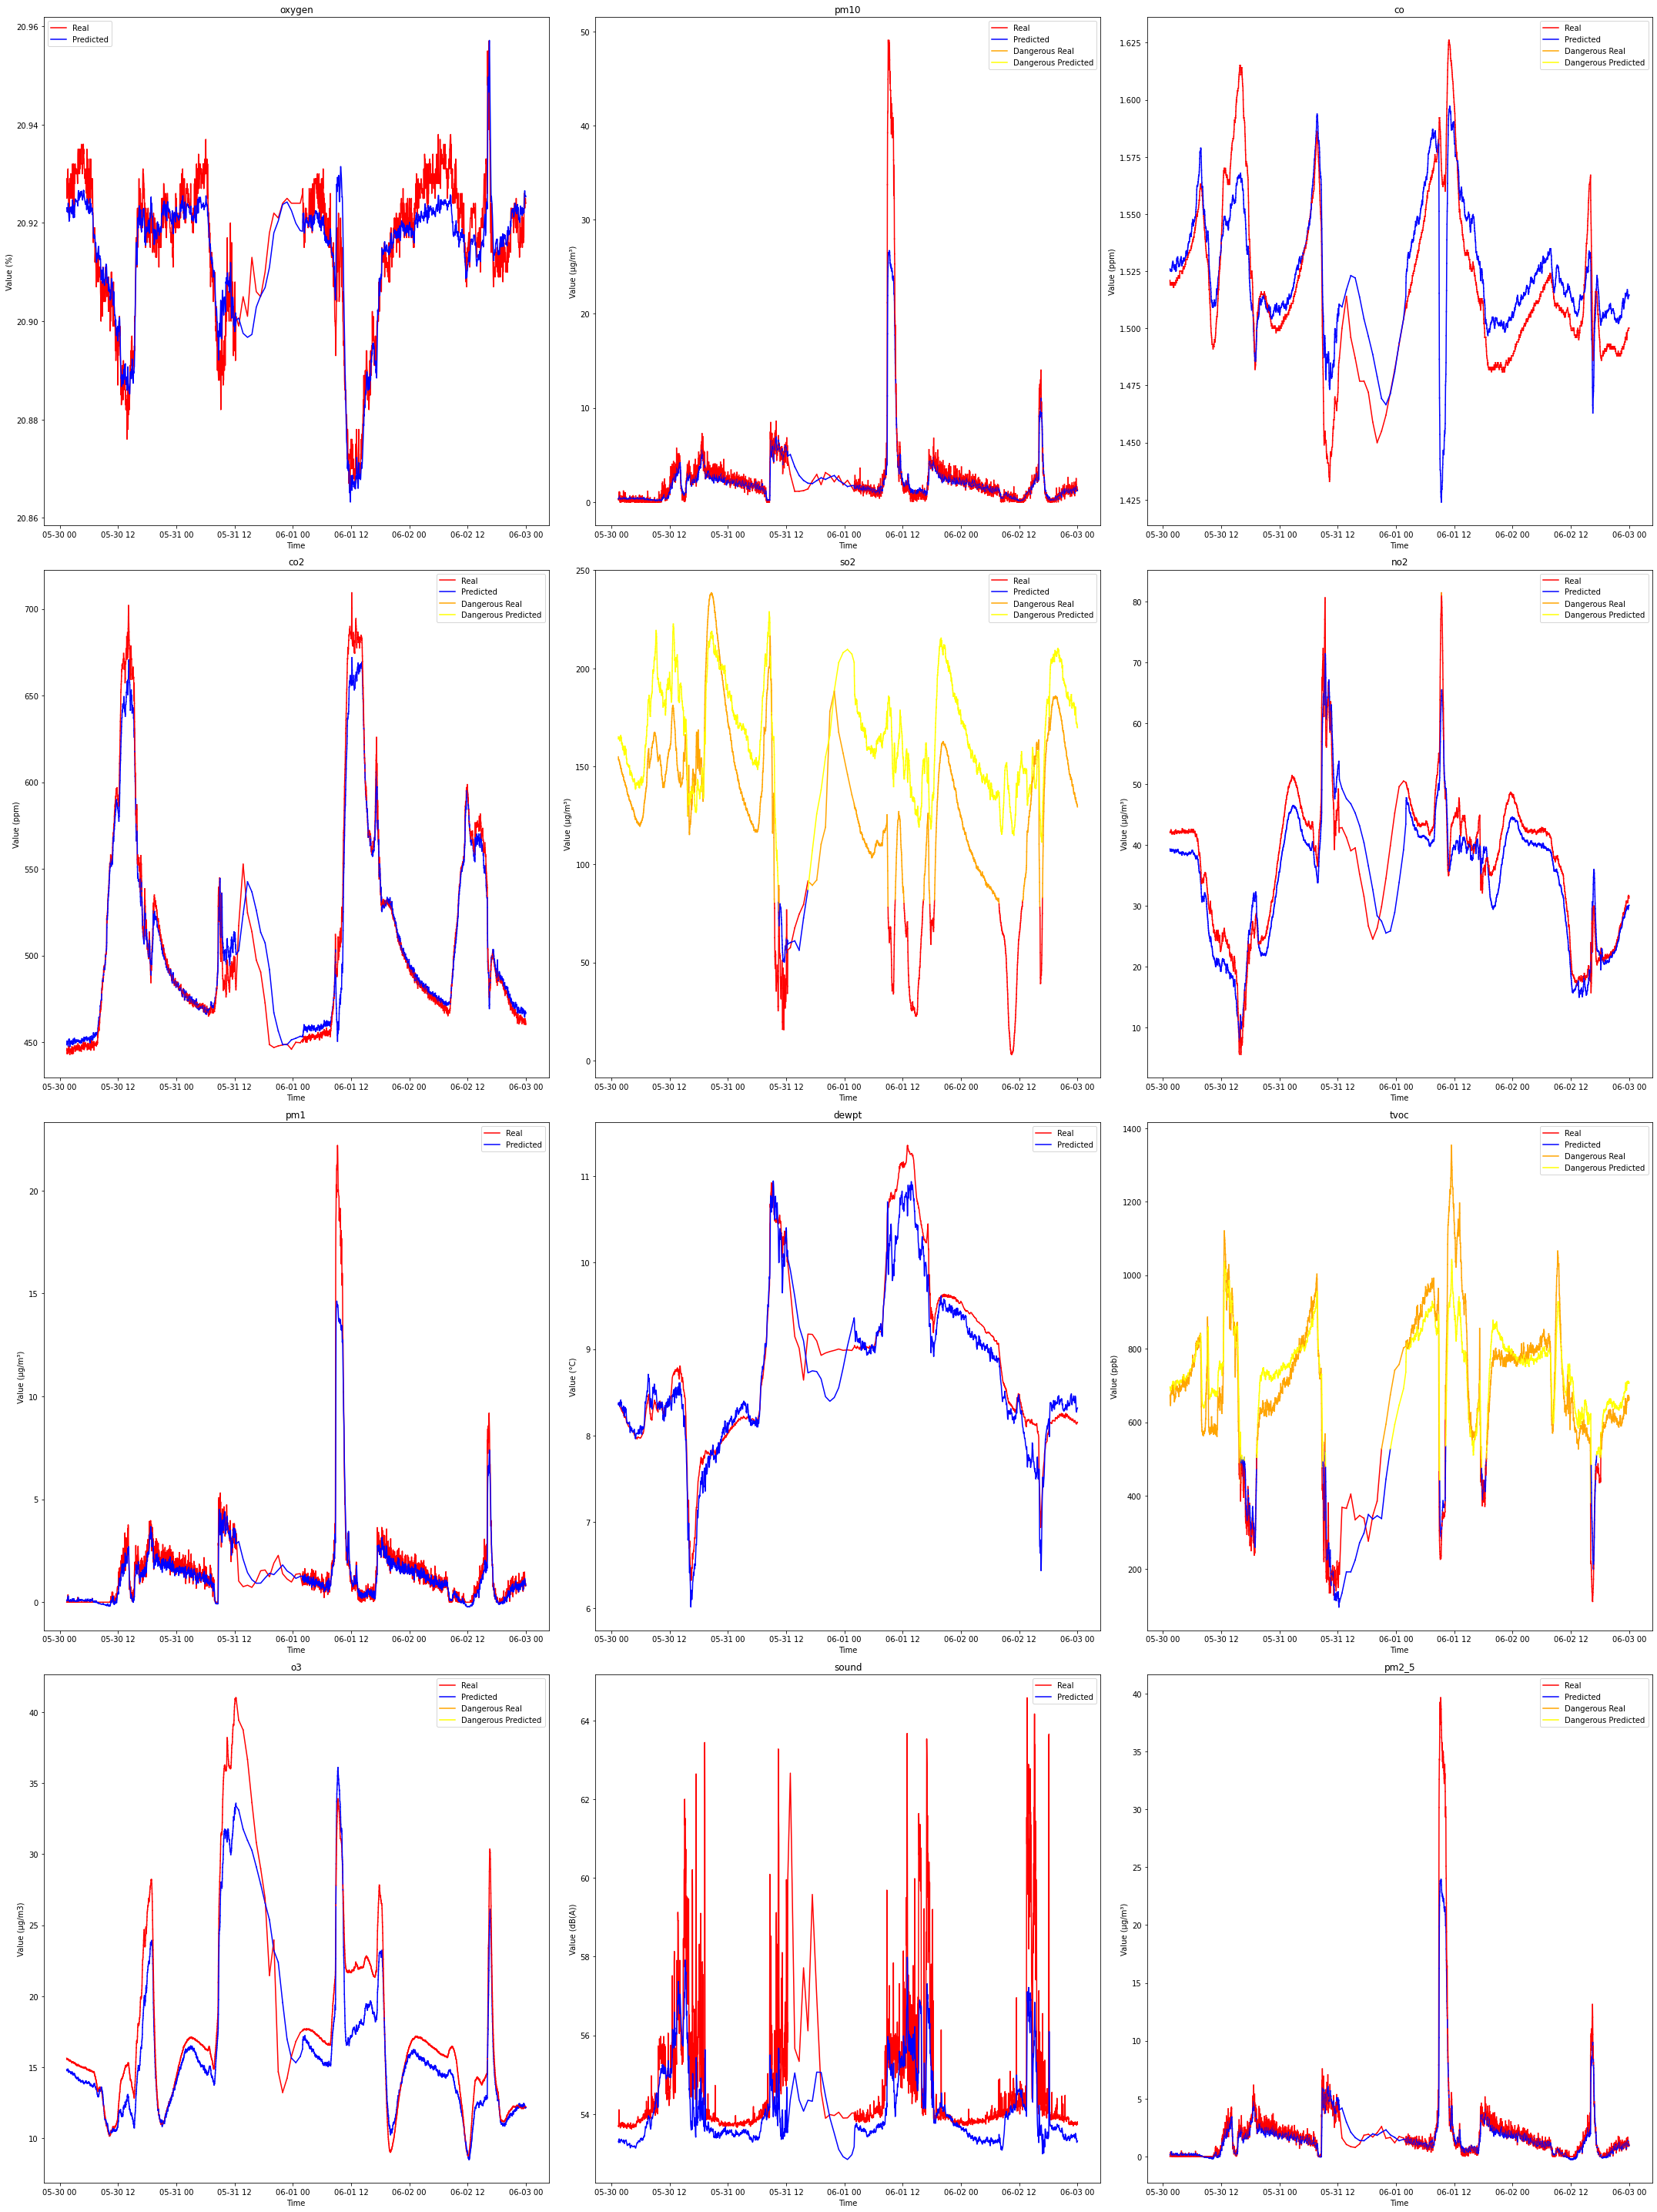

In [20]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [21]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(2427, 12) (2427, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 2.534
Test RMSE for co: 0.024
Test RMSE for co2: 10.465
Test RMSE for so2: 50.226
Test RMSE for no2: 3.738
Test RMSE for pm1: 0.868
Test RMSE for dewpt: 0.240
Test RMSE for tvoc: 78.350
Test RMSE for o3: 2.223
Test RMSE for sound: 1.359
Test RMSE for pm2_5: 1.857


In [22]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [23]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [24]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [25]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [26]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [27]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [28]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [29]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.922867  0.360620  1.526008  448.524994  165.091675  39.322655  0.078453   
1  20.923092  0.363903  1.525557  449.060974  163.995453  39.158531  0.080169   
2  20.922287  0.337368  1.525246  450.643890  164.402115  38.997833  0.057551   
3  20.922373  0.372096  1.525381  449.639557  164.162247  39.030006  0.085304   
4  20.922306  0.442728  1.525341  449.126740  164.340378  39.040146  0.140448   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.376473  695.692688  14.835509  ...  0.141008  0.235013  0.360620   
1  8.353260  694.261597  14.795527  ...  0.142603  0.237671  0.363903   
2  8.358953  691.498108  14.762239  ...  0.116425  0.194042  0.337368   
3  8.371026  687.924866  14.775980  ...  0.150105  0.250175  0.372096   
4  8.378778  685.668884  14.825429  ...  0.216294  0.360490  0.442728   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [30]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.9105892047795633


In [31]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2210


**Multivariate RNN Predictive Modeling**

In [33]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [34]:
n_seconds = 720
n_features = 15

reframed = series_to_supervised(scaled, n_seconds, 1)

In [35]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-720),var2(t-720),var3(t-720),var4(t-720),var5(t-720),var6(t-720),var7(t-720),var8(t-720),var9(t-720),var10(t-720),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
720,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.574194,0.630011,0.114913,0.429063,0.015043,0.185340,0.077491,0.378539,0.317217,0.012206
721,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.574194,0.630300,0.114844,0.433605,0.009188,0.186660,0.076930,0.378350,0.337695,0.005548
722,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.572581,0.636081,0.114712,0.433739,0.001937,0.186893,0.080960,0.377783,0.364544,0.001337
723,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.572581,0.632039,0.114831,0.433443,0.014277,0.190077,0.080595,0.376956,0.337729,0.011324
724,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.574194,0.636372,0.114893,0.434350,0.006801,0.190931,0.081916,0.376672,0.323452,0.008953
725,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.574194,0.638103,0.115003,0.434636,0.011395,0.191707,0.080861,0.376530,0.312856,0.007944
726,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.572581,0.645916,0.115204,0.434798,0.020853,0.193804,0.080686,0.376790,0.341579,0.011853
727,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.572581,0.641245,0.115288,0.432498,0.018511,0.194037,0.080763,0.376838,0.341102,0.012534
728,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.572581,0.649649,0.115476,0.432117,0.021619,0.196211,0.081027,0.375892,0.329688,0.015233
729,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.572581,0.651906,0.115716,0.430466,0.017115,0.197609,0.080922,0.375680,0.332413,0.012685


In [36]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 10800) (28321, 12) (2427, 10800) (2427, 12)


In [37]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2427, 720, 15) (28321, 720, 15)


In [40]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                3300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                612       
Total params: 3,912
Trainable params: 3,912
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
197/197 - 23s - loss: 0.1869 - val_loss: 0.0748
Epoch 2/50
197/197 - 22s - loss: 0.0975 - val_loss: 0.0506
Epoch 3/50
197/197 - 22s - loss: 0.0693 - val_loss: 0.0391
Epoch 4/50
197/197 - 22s - loss: 0.0551 - val_loss: 0.0298
Epoch 5/50
197/197 - 22s - loss: 0.0469 - val_loss: 0.0254
Epoch 6/50
197/197 - 23s - loss: 0.0424 - val_loss: 0.0247
Epoch 7/50
197/197 - 23s - loss: 0.0379 - val_loss: 0.0226
Epoch 8/50
197/197 - 23s - loss: 0.0349 - val_loss: 0.0219
Epoch 9/50
197/197 - 23s - loss: 0.0328 - val_loss: 0.0217
Epoch 10/50
197/197 - 23s - loss: 0.0326 - val_loss: 0.0226
Epoch 11/50
197/197 - 23s - loss: 0.0317 - val_loss: 0.0207
Epoch 12/50
197/197 - 23s - loss: 0.0304 - val_loss: 0.0216
Epoch 13/50
197/197 - 23s - loss: 0.0302 - val_loss: 0.0215
Epoch 14/50
197/197 - 23s - loss: 0.0294 - val_loss: 0.0207
Epoch 15/50
197/197 - 23s - loss: 0.0286 - val_loss: 0.0201
Epoch 16/50
197/197 - 24s - loss: 0.0287 - val_loss: 0.0200
Epoch 17/50
197/197 - 23s - loss: 0.0286 - val_lo

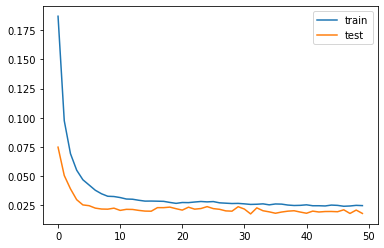

In [41]:
history = model.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6      7   \
0  20.929001  0.371  1.521  445.296997  154.873001  42.080002  0.002  8.364   
1  20.924999  0.270  1.519  446.317993  153.811005  42.009998  0.000  8.363   
2  20.927000  0.242  1.519  443.838989  153.356995  42.216000  0.072  8.361   
3  20.926001  0.446  1.519  443.377014  153.150009  42.146999  0.126  8.357   
4  20.927000  1.010  1.519  443.618988  153.292007  42.096004  0.013  8.354   

           8          9          10     11  
0  673.869019  15.639999  53.695000  0.004  
1  662.783997  15.596998  53.694000  0.006  
2  653.749023  15.551000  53.675999  0.176  
3  645.656006  15.580999  53.896000  0.326  
4  652.192017  15.575000  54.110001  0.043  


In [43]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


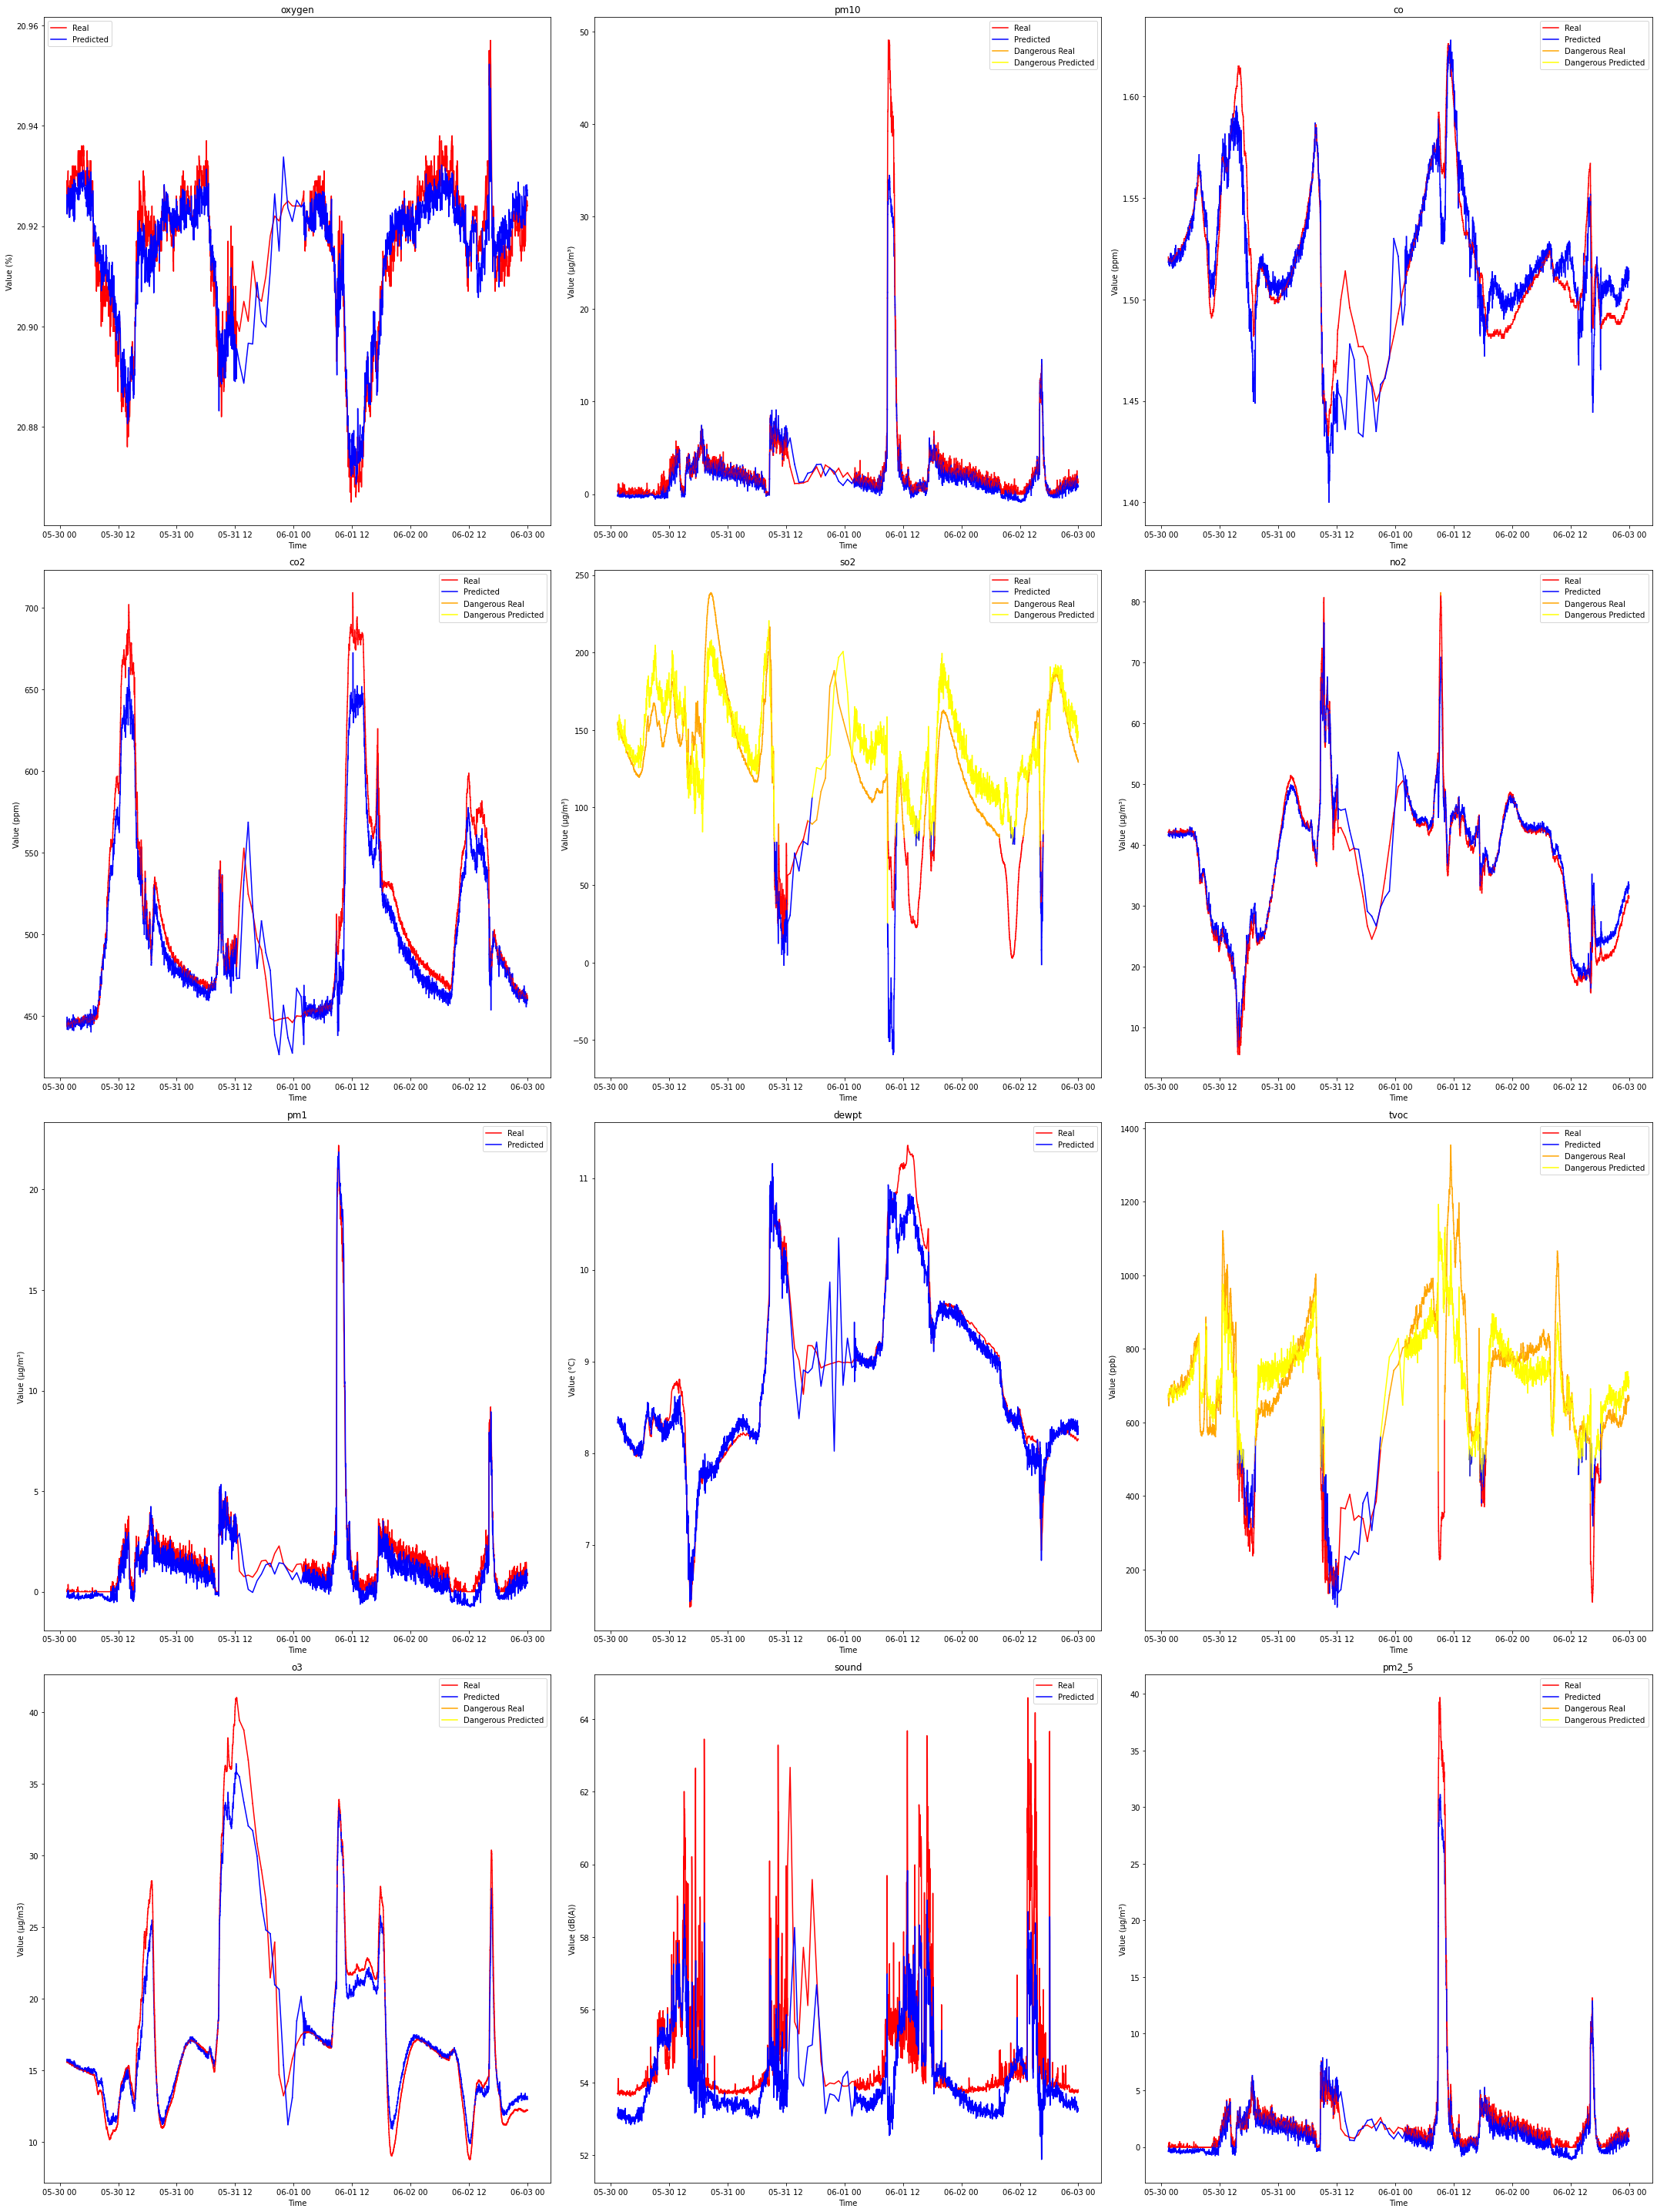

In [44]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [45]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(2427, 12) (2427, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 1.759
Test RMSE for co: 0.014
Test RMSE for co2: 16.692
Test RMSE for so2: 30.163
Test RMSE for no2: 1.877
Test RMSE for pm1: 0.641
Test RMSE for dewpt: 0.198
Test RMSE for tvoc: 132.913
Test RMSE for o3: 1.214
Test RMSE for sound: 1.278
Test RMSE for pm2_5: 1.218


In [46]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [47]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [48]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [49]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [50]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [51]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [52]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.926220 -0.214369  1.518442  444.047821  150.867477  41.699211 -0.276166   
1  20.925623 -0.118846  1.518409  445.913239  150.204361  41.527466 -0.216122   
2  20.922379 -0.172169  1.519293  449.141418  153.330673  41.650299 -0.260938   
3  20.925110  0.008952  1.519510  441.824097  153.927856  41.908104 -0.138298   
4  20.924290  0.158343  1.517246  444.294678  147.183777  41.817226 -0.052816   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.328336  677.812683  15.571056  ... -0.401352 -0.668920 -0.214369   
1  8.347117  673.929871  15.610046  ... -0.312228 -0.520379 -0.118846   
2  8.353240  656.805237  15.759712  ... -0.366617 -0.611028 -0.172169   
3  8.396427  673.378601  15.714111  ... -0.193699 -0.322831  0.008952   
4  8.384112  668.409851  15.705354  ... -0.067400 -0.112334  0.158343   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [53]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7416563658838071


In [54]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1800


**Multivariate GRU Predictive Modeling**

In [55]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [56]:
n_seconds = 720
n_features = 15

reframed = series_to_supervised(scaled, n_seconds, 1)

In [57]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-720),var2(t-720),var3(t-720),var4(t-720),var5(t-720),var6(t-720),var7(t-720),var8(t-720),var9(t-720),var10(t-720),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
720,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.574194,0.630011,0.114913,0.429063,0.015043,0.185340,0.077491,0.378539,0.317217,0.012206
721,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.574194,0.630300,0.114844,0.433605,0.009188,0.186660,0.076930,0.378350,0.337695,0.005548
722,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.572581,0.636081,0.114712,0.433739,0.001937,0.186893,0.080960,0.377783,0.364544,0.001337
723,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.572581,0.632039,0.114831,0.433443,0.014277,0.190077,0.080595,0.376956,0.337729,0.011324
724,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.574194,0.636372,0.114893,0.434350,0.006801,0.190931,0.081916,0.376672,0.323452,0.008953
725,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.574194,0.638103,0.115003,0.434636,0.011395,0.191707,0.080861,0.376530,0.312856,0.007944
726,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.572581,0.645916,0.115204,0.434798,0.020853,0.193804,0.080686,0.376790,0.341579,0.011853
727,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.572581,0.641245,0.115288,0.432498,0.018511,0.194037,0.080763,0.376838,0.341102,0.012534
728,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.572581,0.649649,0.115476,0.432117,0.021619,0.196211,0.081027,0.375892,0.329688,0.015233
729,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.572581,0.651906,0.115716,0.430466,0.017115,0.197609,0.080922,0.375680,0.332413,0.012685


In [58]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 10800) (28321, 12) (2427, 10800) (2427, 12)


In [59]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2427, 720, 15) (28321, 720, 15)


In [60]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                10050     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                612       
Total params: 10,662
Trainable params: 10,662
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
197/197 - 157s - loss: 0.1178 - val_loss: 0.0575
Epoch 2/50
197/197 - 193s - loss: 0.0731 - val_loss: 0.0377
Epoch 3/50
197/197 - 195s - loss: 0.0575 - val_loss: 0.0332
Epoch 4/50
197/197 - 230s - loss: 0.0485 - val_loss: 0.0313
Epoch 5/50
197/197 - 233s - loss: 0.0442 - val_loss: 0.0295
Epoch 6/50
197/197 - 230s - loss: 0.0415 - val_loss: 0.0301
Epoch 7/50
197/197 - 228s - loss: 0.0383 - val_loss: 0.0307
Epoch 8/50
197/197 - 230s - loss: 0.0353 - val_loss: 0.0235
Epoch 9/50
197/197 - 231s - loss: 0.0339 - val_loss: 0.0291
Epoch 10/50
197/197 - 232s - loss: 0.0334 - val_loss: 0.0265
Epoch 11/50
197/197 - 231s - loss: 0.0318 - val_loss: 0.0248
Epoch 12/50
197/197 - 232s - loss: 0.0302 - val_loss: 0.0247
Epoch 13/50
197/197 - 238s - loss: 0.0291 - val_loss: 0.0236
Epoch 14/50
197/197 - 238s - loss: 0.0284 - val_loss: 0.0230
Epoch 15/50
197/197 - 238s - loss: 0.0283 - val_loss: 0.0230
Epoch 16/50
197/197 - 236s - loss: 0.0283 - val_loss: 0.0213
Epoch 17/50
197/197 - 239s - loss

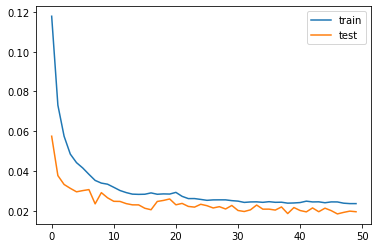

In [61]:
history = model.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [62]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6      7   \
0  20.929001  0.371  1.521  445.296997  154.873001  42.080002  0.002  8.364   
1  20.924999  0.270  1.519  446.317993  153.811005  42.009998  0.000  8.363   
2  20.927000  0.242  1.519  443.838989  153.356995  42.216000  0.072  8.361   
3  20.926001  0.446  1.519  443.377014  153.150009  42.146999  0.126  8.357   
4  20.927000  1.010  1.519  443.618988  153.292007  42.096004  0.013  8.354   

           8          9          10     11  
0  673.869019  15.639999  53.695000  0.004  
1  662.783997  15.596998  53.694000  0.006  
2  653.749023  15.551000  53.675999  0.176  
3  645.656006  15.580999  53.896000  0.326  
4  652.192017  15.575000  54.110001  0.043  


In [63]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


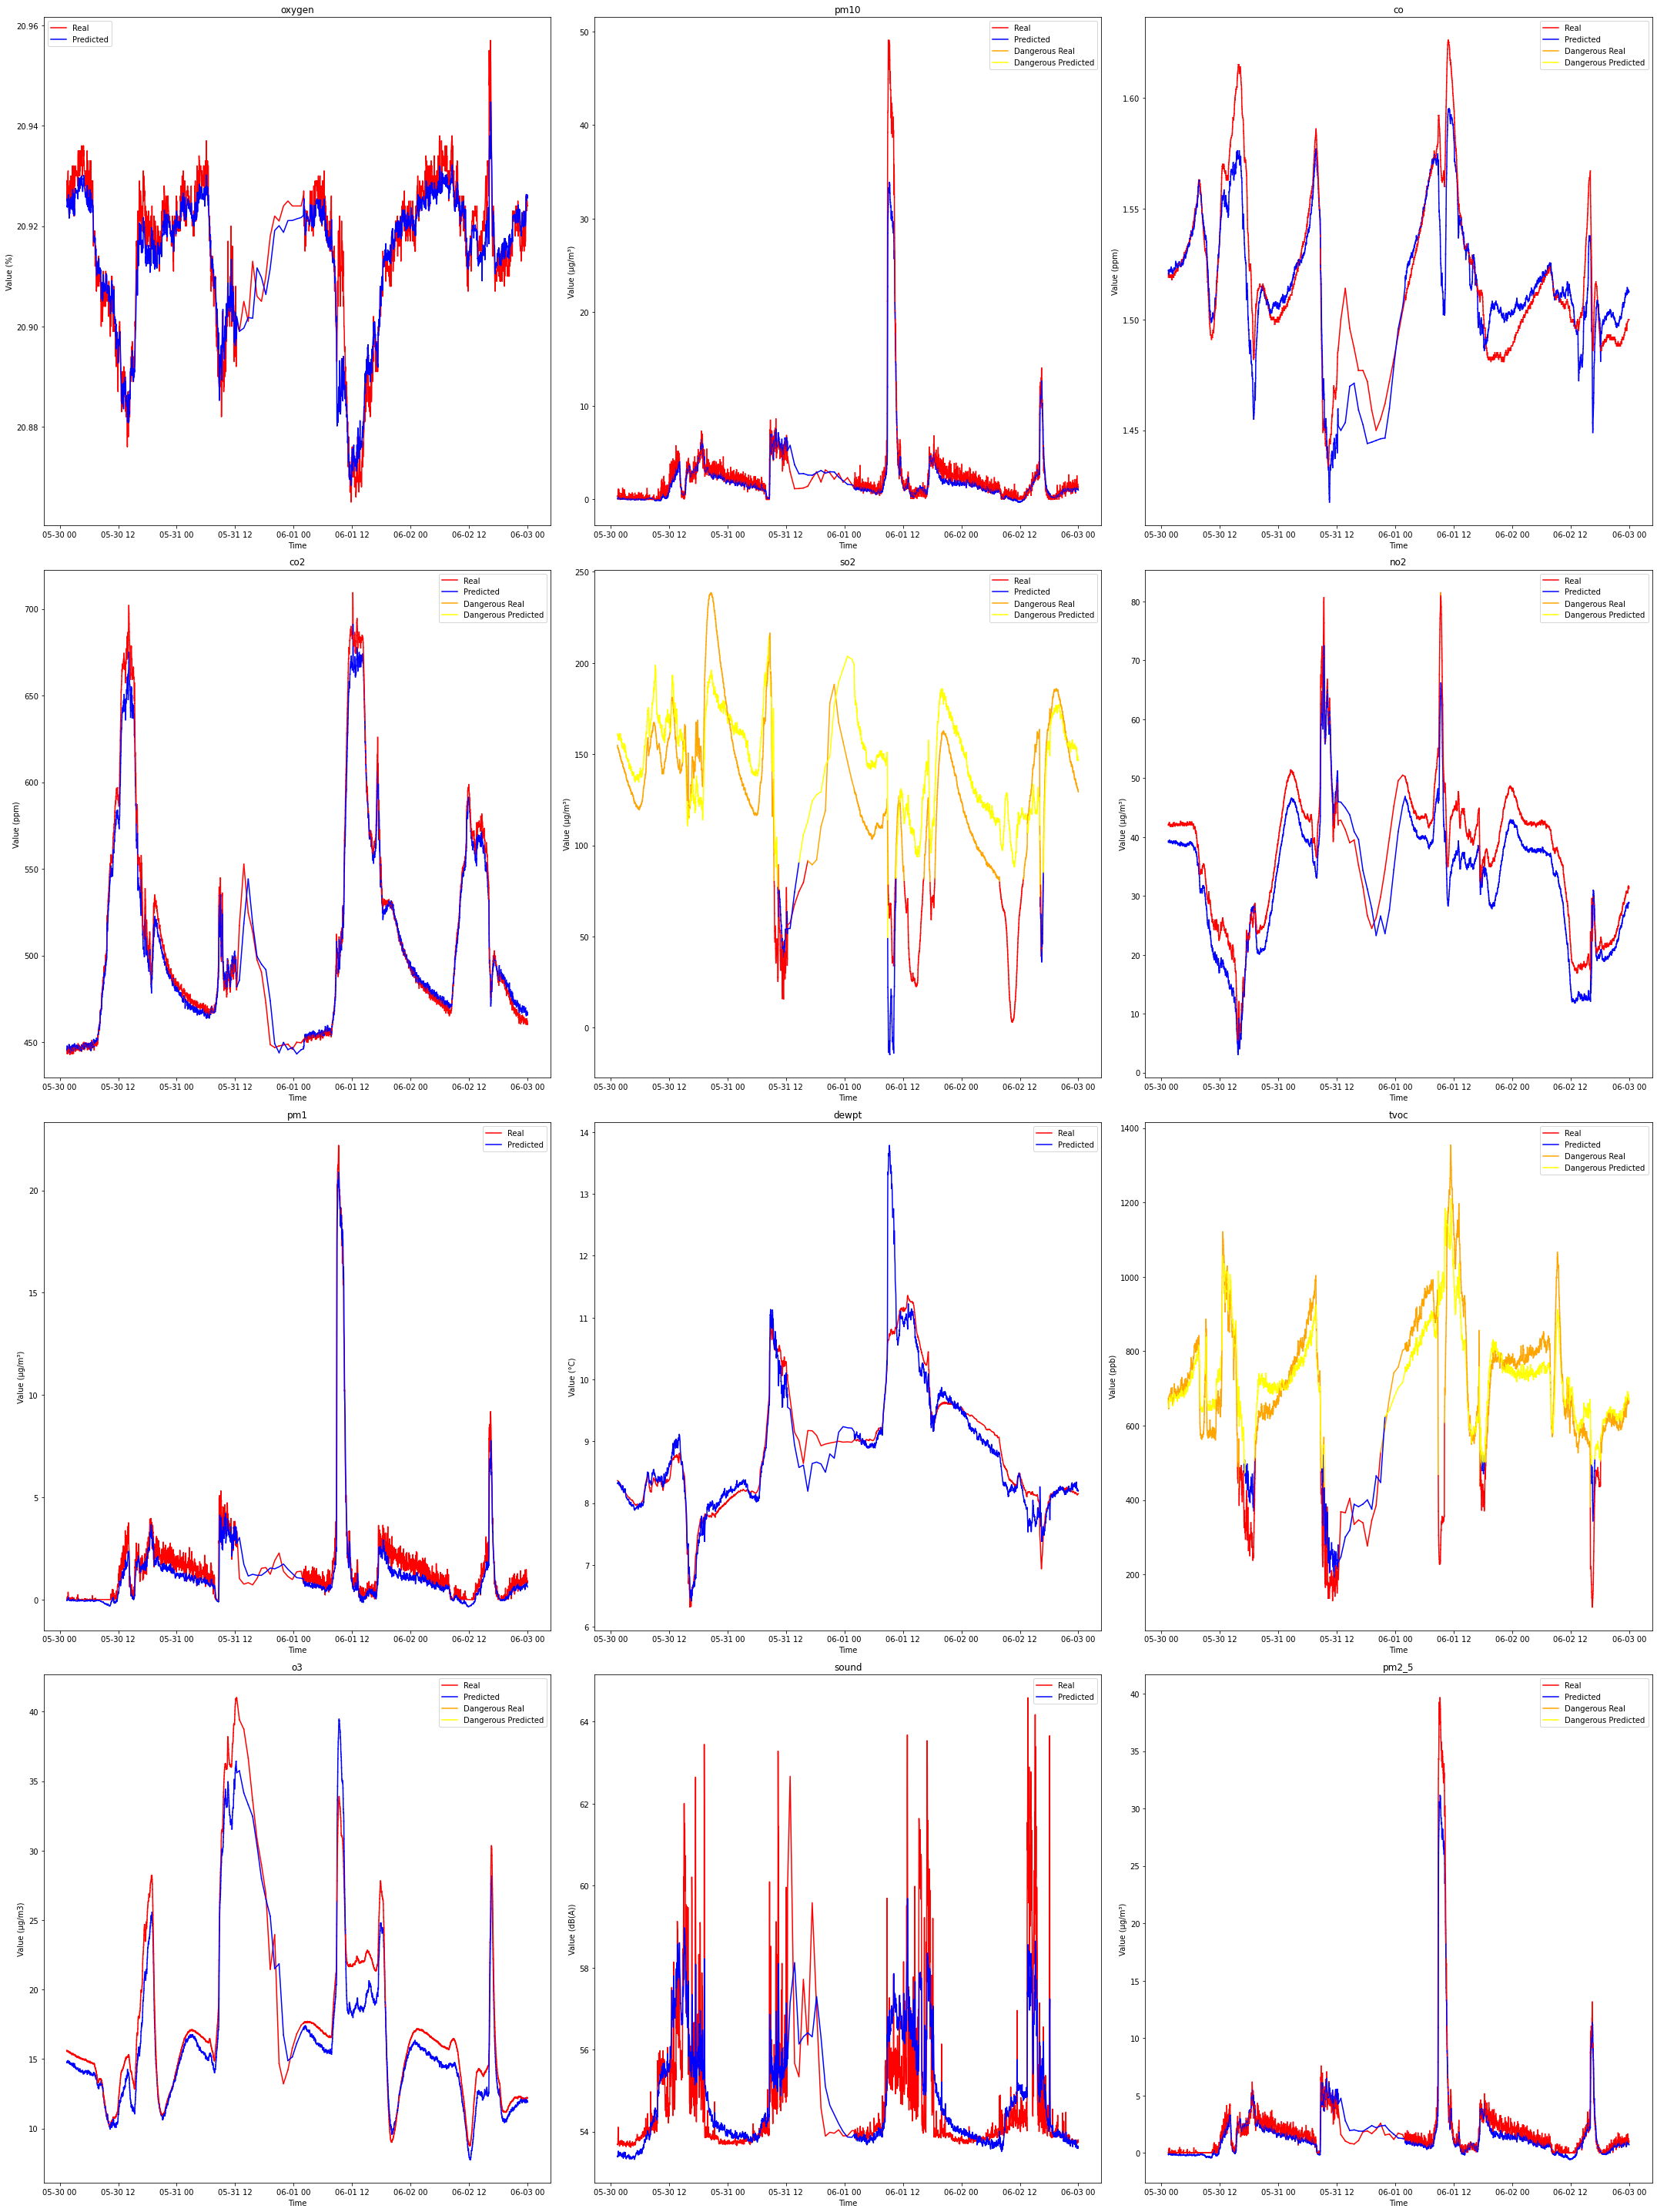

In [64]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [65]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(2427, 12) (2427, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 1.852
Test RMSE for co: 0.016
Test RMSE for co2: 8.023
Test RMSE for so2: 33.338
Test RMSE for no2: 4.879
Test RMSE for pm1: 0.632
Test RMSE for dewpt: 0.379
Test RMSE for tvoc: 113.993
Test RMSE for o3: 1.742
Test RMSE for sound: 1.060
Test RMSE for pm2_5: 1.244


In [66]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [67]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [68]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [69]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [70]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [71]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [72]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.925215  0.070432  1.521874  445.079346  161.206940  39.315434 -0.034915   
1  20.925407  0.068579  1.522289  446.052063  160.324188  39.143620 -0.036550   
2  20.923786  0.059397  1.521819  447.746826  160.267548  39.117126 -0.055328   
3  20.924068  0.082231  1.521053  445.610382  159.869156  39.262188 -0.036693   
4  20.923786  0.137338  1.520641  445.315613  159.194321  39.231869 -0.004988   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.323905  664.869202  14.773751  ... -0.133632 -0.222720  0.070432   
1  8.311926  664.797485  14.741117  ... -0.135703 -0.226171  0.068579   
2  8.320761  655.820496  14.804223  ... -0.150658 -0.251097  0.059397   
3  8.321569  653.786621  14.822357  ... -0.127158 -0.211930  0.082231   
4  8.331740  649.852417  14.846424  ... -0.078110 -0.130184  0.137338   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [73]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8347754429336629


In [74]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2026
